In [1]:
import numpy as np
from matplotlib import pyplot as plt
from io import StringIO
import pandas as pd
from matplotlib.pyplot import cm


%load_ext autoreload
%autoreload 2

In [2]:
tabular_str = """\
	conv4	convnext_base	resnet18	resnet50	swinv2	vit small	vit tiny
bigearthnet	0.5162 ± 0.0114	0.6918 ± 0.002	0.6786 ± 0.0023	0.6636 ± 0.0023	0.6997 ± 0.0027	0.7037 ± 0.0072	0.688 ± 0.0038
brick_kiln_v1.0	0.9377 ± 0.0055	0.9567 ± 0.0095	0.9523 ± 0.0091	0.9497 ± 0.0061	0.9627 ± 0.0064	0.9503 ± 0.0042	0.94 ± 0.0151
eurosat	0.8723 ± 0.0021	0.9843 ± 0.0021	0.9777 ± 0.0051	0.9757 ± 0.004	0.977 ± 0.0026	0.979 ± 0.0035	0.983 ± 0.006
pv4ger_classification	0.9107 ± 0.0071	0.9488 ± 0.0056	0.9469 ± 0.0081	0.9379 ± 0.0052	0.945 ± 0.0069	0.9461 ± 0.0053	0.9367 ± 0.0011
so2sat	0.2366 ± 0.0142	0.4922 ± 0.0188	0.4787 ± 0.0173	0.4662 ± 0.0038	0.5054 ± 0.0102	0.5331 ± 0.0079	0.5003 ± 0.0066"""

In [3]:
def get_mean(val):
    if "±" in val:
        return float(val.split("±")[0])
    else:
        return val

def get_std(val):
    if "±" in val:
        return float(val.split("±")[1])
    else:
        return val

df = pd.read_csv(StringIO(tabular_str), sep='\t', index_col=0)
df_mean = df.applymap(get_mean)
df_std = df.applymap(get_std)


df_mean


,conv4,convnext_base,resnet18,resnet50,swinv2,vit small,vit tiny
bigearthnet,0.5162,0.6918,0.6786,0.6636,0.6997,0.7037,0.6880
brick_kiln_v1.0,0.9377,0.9567,0.9523,0.9497,0.9627,0.9503,0.9400
eurosat,0.8723,0.9843,0.9777,0.9757,0.9770,0.9790,0.9830
pv4ger_classification,0.9107,0.9488,0.9469,0.9379,0.9450,0.9461,0.9367
so2sat,0.2366,0.4922,0.4787,0.4662,0.5054,0.5331,0.5003


In [4]:
class Normalizer:

    def __init__(self, df_mean, df_std, border=0.1):
        self.border = border
        self.range_dict = {}
        df_mean_t = df_mean.transpose()
        df_std_t = df_std.transpose()
        for ds_name in df_mean_t:
            mean = df_mean_t[ds_name].to_numpy()
            std = df_std_t[ds_name].to_numpy()

            self.range_dict[ds_name] = (min(mean-std), max(mean+std))
    
    def __call__(self, ds_name, values, scale_only=False):
        mn, mx = self.range_dict[ds_name]
        range = mx-mn
        if scale_only:
            return values / range
        else:
            return (values - mn)/range

    def from_row(self, row, scale_only=False):
        return [self(ds_name, val, scale_only=scale_only) for ds_name, val in row.items()]
        
        


conv4
convnext_base
resnet18
resnet50
swinv2
vit small
vit tiny


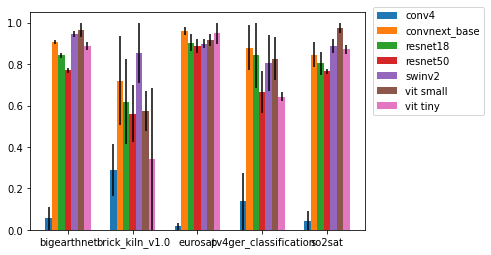

In [5]:
colors = cm.rainbow(np.linspace(0, 1, 7))

normalizer = Normalizer(df_mean, df_std)
for i, backbone in enumerate(df_mean):
    print(backbone)
    ds_names = df_mean[backbone].keys()
    mean = normalizer.from_row(df_mean[backbone])
    err = normalizer.from_row(df_std[backbone], scale_only=True)
    x = np.arange(len(mean)) + i/10 

    if i == 3:
        plt.bar(x, mean, width=0.1, label=backbone, yerr=err,tick_label=ds_names)
    else:
        plt.bar(x, mean, width=0.1, label=backbone, yerr=err, )
plt.legend(bbox_to_anchor=(1.01, 1.05))

# Train Size Analysis

In [6]:
from ccb.experiment.discriminative_metric import pairwise_entropy, boostrap_pw_entropy
plt.rcParams['figure.figsize'] = [20, 10]

def get_train_ratio(part_name):
    return float(part_name.split("x_")[0])

sweep_results_path = "/mnt/data/experiments/nils/classification_results/sweep_results_2022-07-06_12-54-05.csv"
df = pd.read_csv(sweep_results_path)
df['train_ratio'] = [get_train_ratio(part_name) for part_name in df['partition_name']]

def clean_names(val):
    if isinstance(val, str):
        for src, tgt in (("_classification", ""), ("vit_small_patch16_224", "vit_small"), ("swinv2_tiny_window16_256", "swijnv2")):
            val = val.replace(src, tgt)
    return val
df.applymap(clean_names)

def plot_over_train_size(df, metric="test_metric", log_y=False, n_largest=4, min_results=3):
    models = df["model"].unique()
    datasets = df['dataset'].unique()
    train_ratios = np.sort(df['train_ratio'].unique())

    fig, axes = plt.subplots(len(datasets), len(models))
    fig.suptitle(metric, fontsize=20)

    for i, dataset in enumerate(datasets):
        for j, model in enumerate(models):
            axes[i, j].set_title(f"{model} on {dataset}")
            for k, train_ratio in enumerate(train_ratios):
                sub_df = df[(df["dataset"] == dataset) & (df['train_ratio'] == train_ratio) & (df['model'] == model)]
                if len(sub_df) < min_results: 
                    data = [np.nan]
                else:
                    sub_df = sub_df.nlargest(n_largest, columns="val_metric")
                    data = sub_df[metric].to_numpy()

                axes[i, j].boxplot(data, positions=[k])
                if log_y:
                    axes[i, j].set_yscale("log")
            axes[i, j].set_xticklabels([str(trn_ratio) for trn_ratio in train_ratios])
    fig.tight_layout()
 


In [12]:


# sweep_results_path = "/mnt/data/experiments/nils/classification_results/sweep_results_2022-07-20_11-24-05.csv"
# df = pd.read_csv(sweep_results_path)


seeded_results_path = "/mnt/data/experiments/nils/classification_results/seeded_runs_2022-07-25_11-01-58.csv"
df = pd.read_csv(seeded_results_path)

df['train_ratio'] = [get_train_ratio(part_name) for part_name in df['partition_name']]

def clean_names(val):
    if isinstance(val, str):
        for src, tgt in (("_classification", ""), ("_patch16_224", ""), ("swinv2_tiny_window16_256", "swinv2")):
            val = val.replace(src, tgt)
    return val

df = df.applymap(clean_names)
print(df['model'].unique())
print(df['dataset'].unique())

['resnet18' 'conv4' 'convnext_base' 'vit_tiny' 'swinv2' 'vit_small'
 'resnet50']
['so2sat' 'brick_kiln_v1.0' 'eurosat' 'pv4ger' 'forestnet_v1.0'
 'bigearthnet' 'geolifeclef-2022']


/tmp/ipykernel_26428/1116575562.py:41: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


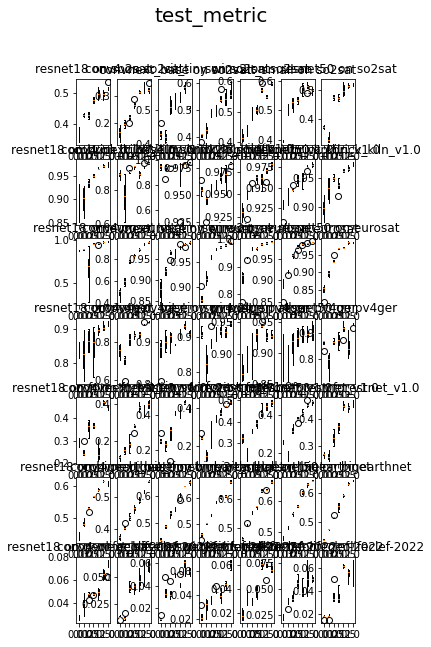

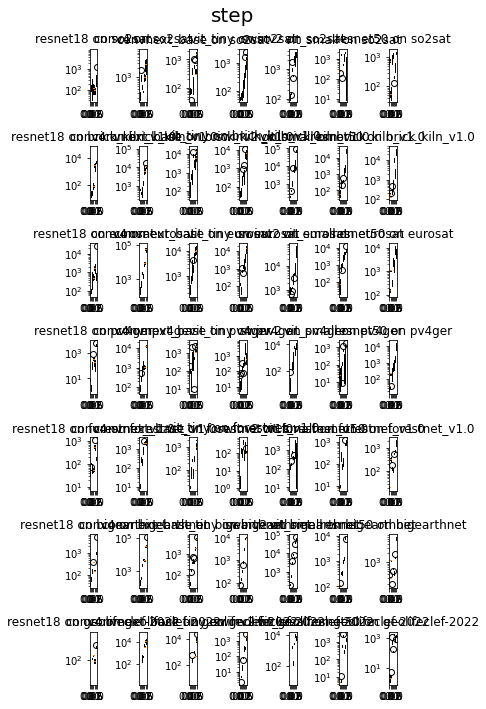

In [13]:

plot_over_train_size(df, metric="test_metric")
plot_over_train_size(df, metric="step", log_y=True)


plt.show()   

In [14]:
df["model"].unique()

array(['resnet18', 'conv4', 'convnext_base', 'vit_tiny', 'swinv2',
       'vit_small', 'resnet50'], dtype=object)

so2sat
brick_kiln_v1.0
eurosat
pv4ger
forestnet_v1.0
bigearthnet
geolifeclef-2022


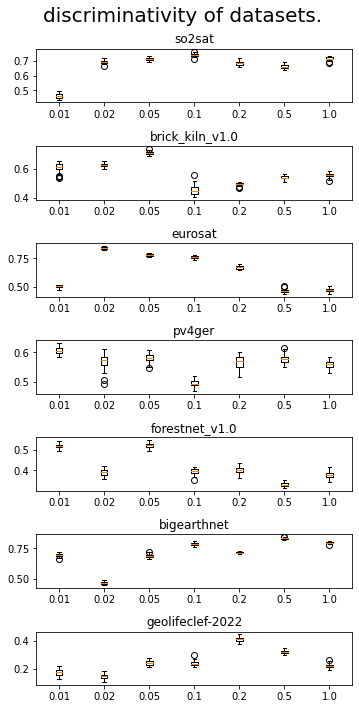

In [24]:
plt.rcParams['figure.figsize'] = [5, 10]


def plot_discriminative_metric(df, metric="test_metric", n_largest=3):
    models = df["model"].unique()
    datasets = df['dataset'].unique()
    train_ratios = np.sort(df['train_ratio'].unique())

    fig, axes = plt.subplots(len(datasets), 1)
    fig.suptitle("discriminativity of datasets.", fontsize=20)


    for i, dataset in enumerate(datasets):

        print(dataset)
        discr_val = []
        for k, train_ratio in enumerate(train_ratios):

            # print(f"  train ratio : {train_ratio}")

            all_scores = []
            for j, model in enumerate(models):
                sub_df = df[(df["dataset"] == dataset) & (df['train_ratio'] == train_ratio) & (df['model'] == model)]
                sub_df = sub_df.nlargest(n_largest, columns="val_metric")
                scores = sub_df[metric].to_numpy()
                if len(scores) == 0:
                    print(f"  train ration: {train_ratio}: missing {model}")
                # print(f"    {j}: {scores}")
                all_scores.append(scores)
            
            # pw_entr = pairwise_entropy(all_scores)
            
            pw_entr_list = boostrap_pw_entropy(all_scores, repeat=50, std_ratio=0.2, replace=False)
            # print(f"    pw entr: {pw_entr}")
            axes[i].boxplot(1 - np.array(pw_entr_list), positions=[k])

            # discr_val.append(1 - pw_entr)
        
        axes[i].set_title(f"{dataset}")
        # axes[i].set_ylim((0.5,1))
        # axes[i].plot(np.arange(len(discr_val)), discr_val, marker='.')
        axes[i].set_xticklabels([str(trn_ratio) for trn_ratio in train_ratios])
    fig.tight_layout()

plot_discriminative_metric(df, metric="val_metric", n_largest=100)

In [16]:
df[(df["dataset"] == "eurosat") & (df["model"] == "resnet18") & (df["train_ratio"] == 0.01)]

,train_loss,train_metric,val_loss,val_metric,test_loss,test_metric,step,epoch,unix_time,dataset,model,partition_name,benchmark_name,batch_size,exp_dir,csv_log_dir,train_ratio
1498,0.041523,0.981481,0.332690,0.888,0.355263,0.884,77.0,25,128.0,eurosat,resnet18,0.01x_train,classification_v0.5,64,/mnt/data/experiments/nils/new_partition_seeds...,/mnt/data/experiments/nils/new_partition_seeds...,0.01
1741,0.106289,0.969136,0.331302,0.897,0.391664,0.888,68.0,22,128.0,eurosat,resnet18,0.01x_train,classification_v0.5,64,/mnt/data/experiments/nils/new_partition_seeds...,/mnt/data/experiments/nils/new_partition_seeds...,0.01
2207,0.073018,0.987654,0.342392,0.886,0.432962,0.874,77.0,25,256.0,eurosat,resnet18,0.01x_train,classification_v0.5,64,/mnt/data/experiments/nils/new_partition_seeds...,/mnt/data/experiments/nils/new_partition_seeds...,0.01
2488,0.063080,0.962963,0.342166,0.907,0.404690,0.881,80.0,26,256.0,eurosat,resnet18,0.01x_train,classification_v0.5,64,/mnt/data/experiments/nils/new_partition_seeds...,/mnt/data/experiments/nils/new_partition_seeds...,0.01
2788,0.121695,0.975309,0.317548,0.896,0.403116,0.873,74.0,24,128.0,eurosat,resnet18,0.01x_train,classification_v0.5,64,/mnt/data/experiments/nils/new_partition_seeds...,/mnt/data/experiments/nils/new_partition_seeds...,0.01
2832,0.199622,0.950617,0.325767,0.896,0.397665,0.877,59.0,19,128.0,eurosat,resnet18,0.01x_train,classification_v0.5,64,/mnt/data/experiments/nils/new_partition_seeds...,/mnt/data/experiments/nils/new_partition_seeds...,0.01
2851,0.106865,0.956790,0.351355,0.878,0.372633,0.889,41.0,13,128.0,eurosat,resnet18,0.01x_train,classification_v0.5,64,/mnt/data/experiments/nils/new_partition_seeds...,/mnt/data/experiments/nils/new_partition_seeds...,0.01
3041,0.094610,0.981481,0.375542,0.882,0.401440,0.880,53.0,17,128.0,eurosat,resnet18,0.01x_train,classification_v0.5,64,/mnt/data/experiments/nils/new_partition_seeds...,/mnt/data/experiments/nils/new_partition_seeds...,0.01
3192,0.036071,0.993827,0.325555,0.893,0.435533,0.873,92.0,30,128.0,eurosat,resnet18,0.01x_train,classification_v0.5,64,/mnt/data/experiments/nils/new_partition_seeds...,/mnt/data/experiments/nils/new_partition_seeds...,0.01
3291,0.122567,0.962963,0.309440,0.898,0.394884,0.886,68.0,22,128.0,eurosat,resnet18,0.01x_train,classification_v0.5,64,/mnt/data/experiments/nils/new_partition_seeds...,/mnt/data/experiments/nils/new_partition_seeds...,0.01
